In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
winequality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = winequality.data.features
y = winequality.data.targets

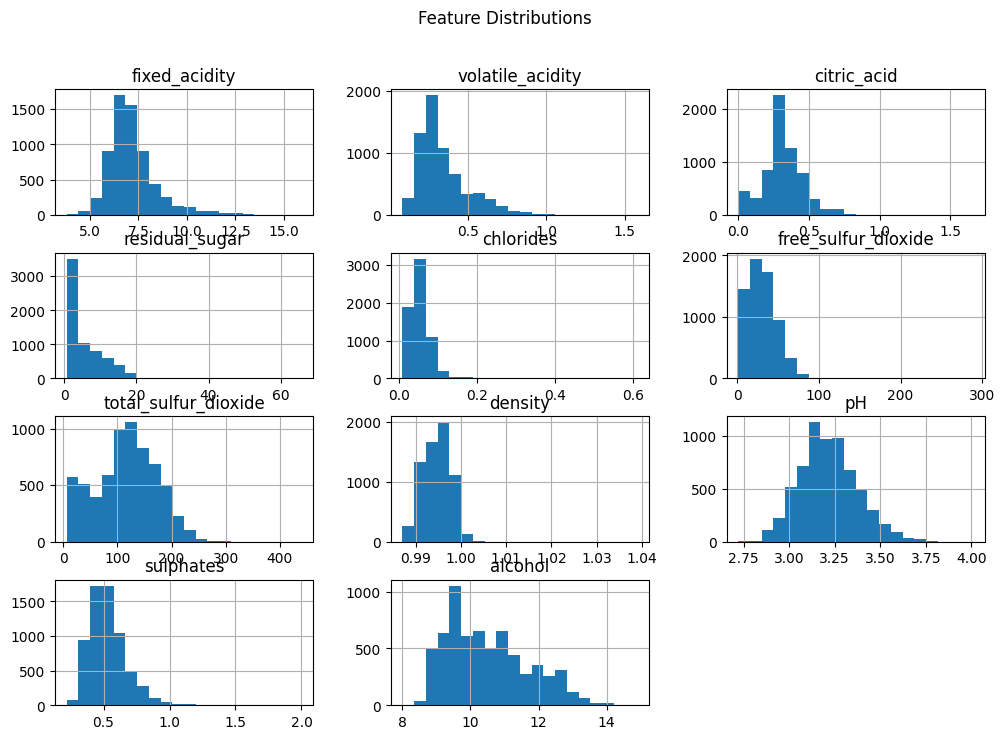

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

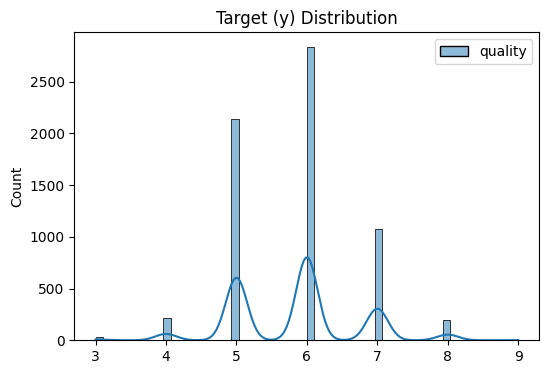

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

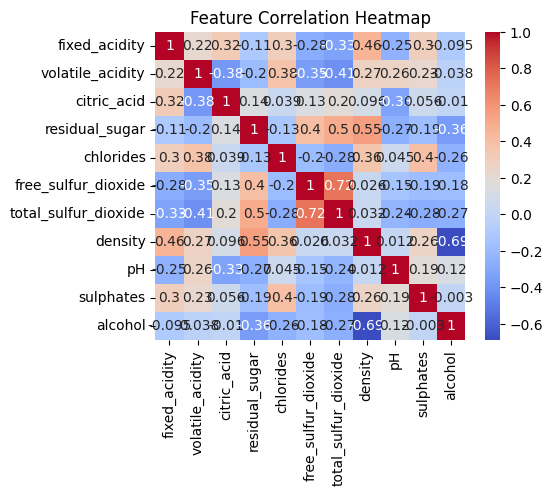

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.158033                 1.044375             1.251156   
1                  1.334972                 1.167949             1.087998   
2                  1.257169                 1.052763             1.190767   
3                  1.230124                 1.178306             1.091954   
4                  1.108950                 1.177739             1.437864   
mean               1.217850                 1.124226             1.211948   
std                0.087823                 0.069251             0.143863   

      DefaultBART_Rhat_RMSE  
0                  1.596865  
1                  1.255078  
2                  1.143354  
3                  1.404728  
4                  1.555566  
mean               1.391118  
std                0.193297  


In [10]:
rhat_df.to_csv("results/real2_WineQuality_rhat.csv", index=False)

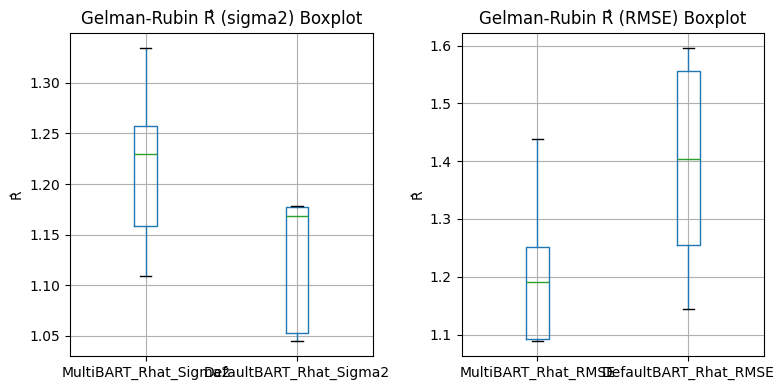

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.476563  0.475149  0.476685  0.489666  0.389235  0.423869
1      0.443859  0.453596  0.463041  0.453220  0.359287  0.416377
2      0.476452  0.485031  0.494605  0.496642  0.384622  0.407832
3      0.450231  0.466439  0.462256  0.469608  0.346424  0.386311
4      0.457659  0.458095  0.455026  0.463368  0.363344  0.391157
5      0.448332  0.469455  0.468411  0.465591  0.369662  0.415728
6      0.459897  0.480168  0.481846  0.487511  0.377460  0.403745
7      0.477120  0.475095  0.477520  0.475487  0.379783  0.425224
8      0.418051  0.418475  0.444487  0.434848  0.332221  0.366885
9      0.495941  0.506482  0.498259  0.516758  0.427461  0.448023
mean   0.460410  0.468798  0.472214  0.475270  0.372950  0.408515
std    0.022074  0.023039  0.016940  0.023387  0.026017  0.022950



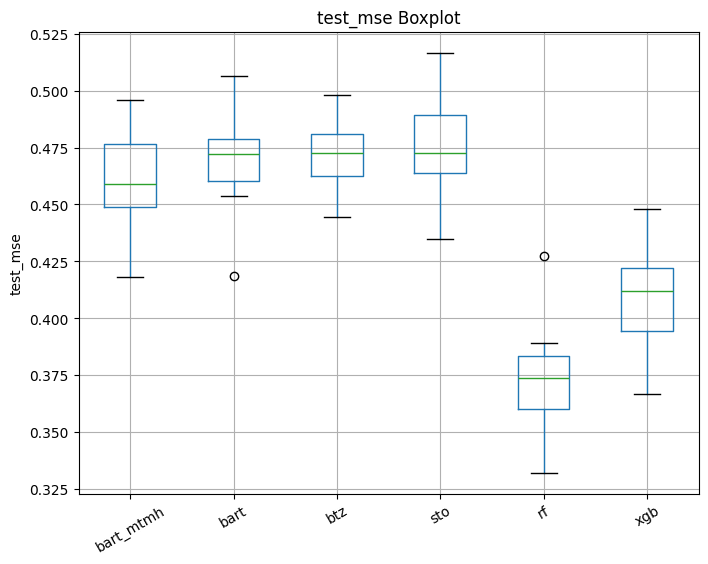

train_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.303997  0.380245  0.405461  0.423812  0.051776  0.063149
1      0.307648  0.389619  0.415851  0.419003  0.053084  0.067435
2      0.307679  0.381564  0.400854  0.413794  0.051887  0.057334
3      0.319844  0.396719  0.419258  0.419697  0.054751  0.057431
4      0.308027  0.387565  0.411875  0.419187  0.051670  0.068970
5      0.311277  0.393155  0.409502  0.423069  0.051974  0.068156
6      0.307254  0.389537  0.405331  0.412114  0.051510  0.060060
7      0.309119  0.383729  0.405558  0.389626  0.051897  0.070524
8      0.326064  0.399377  0.428525  0.433555  0.053018  0.065569
9      0.296065  0.375470  0.393874  0.413191  0.049368  0.059666
mean   0.309698  0.387698  0.409609  0.416705  0.052093  0.063829
std    0.008226  0.007550  0.009838  0.011404  0.001376  0.004957



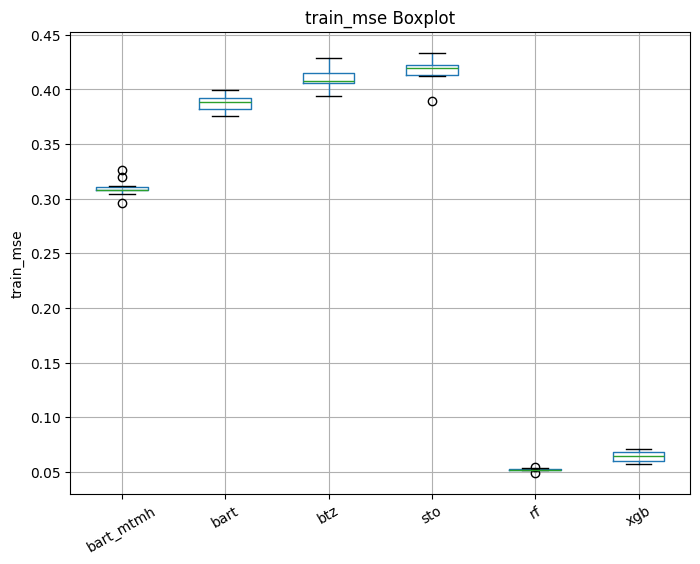

pi_length:
      bart_mtmh      bart       btz       sto
0      2.449112  2.552075  2.656421  1.898469
1      2.476484  2.593169  2.669671  1.870018
2      2.479201  2.567846  2.650855  1.862125
3      2.502498  2.589958  2.680018  1.876185
4      2.442035  2.567581  2.660093  1.846992
5      2.490386  2.584064  2.656796  1.912946
6      2.459593  2.558997  2.663312  1.840376
7      2.468339  2.556167  2.657804  1.787883
8      2.507406  2.623918  2.704633  1.949327
9      2.413977  2.531472  2.636208  1.848365
mean   2.468903  2.572525  2.663581  1.869269
std    0.028778  0.026045  0.018399  0.044298



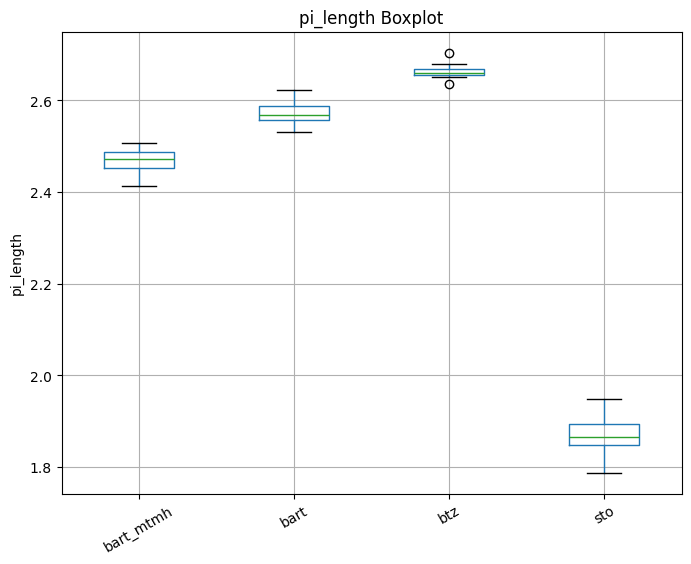

coverage:
      bart_mtmh      bart       btz       sto
0      0.930462  0.932923  0.942769  0.819077
1      0.939077  0.940308  0.952000  0.815385
2      0.929231  0.934154  0.938462  0.794462
3      0.931692  0.939692  0.944000  0.801231
4      0.936615  0.942769  0.942769  0.814154
5      0.936615  0.940308  0.937231  0.822154
6      0.930462  0.942769  0.939077  0.798154
7      0.932308  0.931692  0.938462  0.803077
8      0.950154  0.951385  0.955077  0.837538
9      0.915692  0.924923  0.938462  0.804308
mean   0.933231  0.938092  0.942831  0.810954
std    0.008728  0.007374  0.006130  0.013185



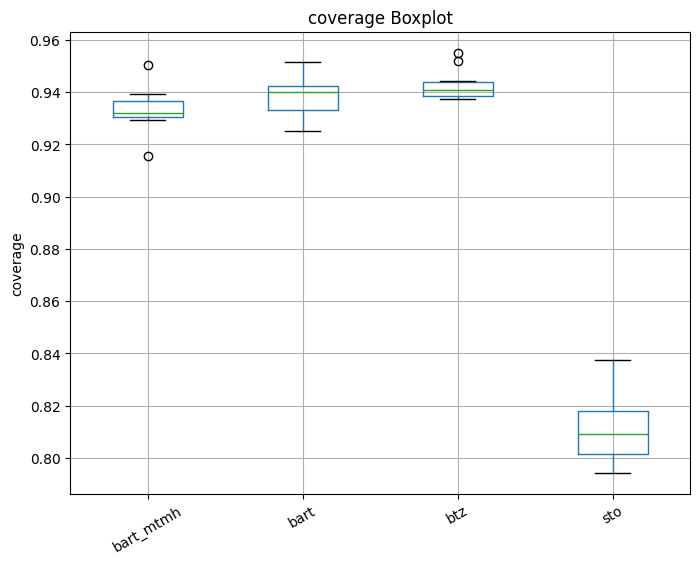

train_time:
       bart_mtmh       bart        btz        sto        rf       xgb
0     197.646426  25.088576  38.726187  55.261681  2.785391  0.202032
1     197.616264  24.880104  37.997702  55.438949  2.745008  0.168606
2     195.596659  24.764032  36.385534  57.316845  2.787353  0.171971
3     197.191909  24.947789  37.537082  55.684990  2.810267  0.149311
4     197.452088  25.157550  38.238980  55.367028  2.746801  0.200282
5     208.867563  35.372895  29.411308  54.149058  2.794955  0.072981
6     204.538835  29.767566  29.792446  55.362950  2.721797  0.073041
7     200.542149  26.815620  25.787769  60.044240  2.849249  0.081048
8     202.120855  28.756766  28.842060  56.708372  2.781736  0.073261
9     206.134543  33.320131  29.423244  54.319436  2.731676  0.070209
mean  200.770729  27.887103  33.214231  55.965355  2.775423  0.126274
std     4.480912   3.854475   4.967295   1.719032  0.039245  0.057058



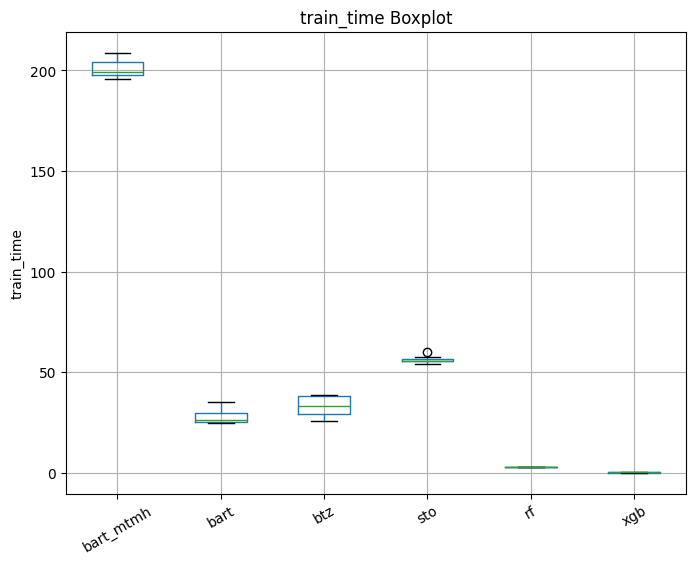

In [9]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [10]:
for k, v in mse_results.items():
    csv_name = f"results/real2_WineQuality_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real2_WineQuality_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real2_WineQuality_tries.csv", index=False)

In [12]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.091378   1.400689  0.473605  0.937846    42.679729
1            5     1.195244   1.138847  0.466345  0.937231   116.756962
2           10     1.136054   1.196634  0.460210  0.933169   200.768393
3           50     1.366364   1.208860  0.455920  0.927508   954.844307
4          100     1.256161   1.173589  0.450414  0.927385  1931.901623
